##### Imports & Data Loading

##### **TASKS:**
##### **- Generate ROC comparison between hand/age/gender**
##### - Save models for hand/age/gender
##### **- OPTIONAL: restructure train/val/test by writing prompt (i.e., LND,WOZ,PHR)**

In [ ]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.applications import ResNet50V2, EfficientNetB1
from keras import layers
from tensorflow import data as tf_data
import os
import random
import zipfile
import shutil
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
import reload_data2 as reload_data

In [ ]:
IMAGE_SIZE=(256,256)
BATCH_SIZE = 64

# ROC COMPARISON

In [ ]:
gender = keras.models.load_model("/content/MobileNetV2_gender.keras")
age = keras.models.load_model("/content/MobileNetV2_age.keras")
hand = keras.models.load_model("/content/MobileNetV2_hand.keras")

In [ ]:
age.summary()

Model: "mobilenet_gender"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_2 (TrueDivide)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_2 (Subtract)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 8, 1280)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,829 (8.63 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 2,564 (10.02 KB)

In [ ]:
gender_df = pd.read_csv("/content/gender_df.csv")
age_df = pd.read_csv("/content/age_df.csv")
hand_df = pd.read_csv("/content/hand_df.csv")

In [19]:
try:
    shutil.rmtree("/content/Data1")
except:
    pass

source_dir = "/content/Data1"

reload_data.full_unzip_and_stratify("/content/CSAFE_Handwriting_Images.zip","/content/Data1")

for current_dir in ["/content/Data1/val","/content/Data1/train","/content/Data1/test"]:
    os.mkdir(f"{current_dir}/male")
    male_dir = f"{current_dir}/male"
    os.mkdir(f"{current_dir}/female")
    female_dir = f"{current_dir}/female"

    for w_folder in list(os.listdir(current_dir)): #w_folders = writer ids
        if w_folder in ["male", "female"]:  # skip your new folders
            continue

        id = int(w_folder[2:])
        cat = gender_df.loc[gender_df["wid"] == id, "gender"].iloc[0]

        if cat == "male":
            # Move the entire folder 'source_folder' into 'destination_folder'
            shutil.move(f"{current_dir}/{w_folder}", male_dir)
        elif cat == "female":
            shutil.move(f"{current_dir}/{w_folder}", female_dir)
        else:
            print(f"SKIPPED: {w_id} --> {cat}")

_,_,gen_X_test = reload_data.train_val_test_split(
    source_dir,IMAGE_SIZE,BATCH_SIZE=BATCH_SIZE)

gender_pred = gender.predict(gen_X_test)

#################################################################################################
#################################################################################################
#################################################################################################

source_dir = "/content/Data2"

reload_data.full_unzip_and_stratify("/content/CSAFE_Handwriting_Images.zip","/content/Data2")

for current_dir in ["/content/Data2/val","/content/Data2/train","/content/Data2/test"]:
    for group in age_df["agegroup"].unique():
        os.mkdir(f"{current_dir}/{group}")
        #dir = f"{current_dir}/{group}"

    for w_folder in list(os.listdir(current_dir)): #w_folders = writer ids
        if w_folder in age_df["agegroup"].unique():  # skip your new folders
            continue

        id = int(w_folder[2:])
        cat = age_df.loc[age_df["wid"] == id, "agegroup"].iloc[0]

        if cat in age_df["agegroup"].unique():
            # Move the entire folder 'source_folder' into 'destination_folder'
            shutil.move(f"{current_dir}/{w_folder}", f"{current_dir}/{cat}")
        else:
            print(f"SKIPPED: {w_id} --> {cat}")

_,_,age_X_test = reload_data.train_val_test_split(
    source_dir,IMAGE_SIZE,BATCH_SIZE=BATCH_SIZE)

age_pred = age.predict(age_X_test)


#################################################################################################
#################################################################################################
#################################################################################################

source_dir = "/content/Data3"

reload_data.full_unzip_and_stratify("/content/CSAFE_Handwriting_Images.zip","/content/Data3")

for current_dir in ["/content/Data3/val","/content/Data3/train","/content/Data3/test"]:
    os.mkdir(f"{current_dir}/right")
    right_dir = f"{current_dir}/right"
    os.mkdir(f"{current_dir}/left")
    left_dir = f"{current_dir}/left"

    for w_folder in list(os.listdir(current_dir)): #w_folders = writer ids
        if w_folder in ["right", "left"]:  # skip your new folders
            continue

        id = int(w_folder[2:])
        cat = hand_df.loc[hand_df["wid"] == id, "hand"].iloc[0]

        if cat == "right":
            # Move the entire folder 'source_folder' into 'destination_folder'
            shutil.move(f"{current_dir}/{w_folder}", right_dir)
        elif cat == "left":
            shutil.move(f"{current_dir}/{w_folder}", left_dir)
        elif cat == "ambidextrous":
            shutil.rmtree(f"{current_dir}/{w_folder}")
        else:
            print(f"SKIPPED: {w_id} --> {cat}")

_,_,hand_X_test = reload_data.train_val_test_split(
    source_dir,IMAGE_SIZE,BATCH_SIZE=BATCH_SIZE)

hand_pred = hand.predict(hand_X_test)

Found 1350 files belonging to 90 classes.
Found 540 files belonging to 90 classes.
Found 540 files belonging to 90 classes.
Found 1350 files belonging to 2 classes.
Found 540 files belonging to 2 classes.
Found 540 files belonging to 2 classes.
9/9 ━━━━━━━━━━━━━━━━━━━━ 373s 40s/step
Found 1350 files belonging to 90 classes.
Found 540 files belonging to 90 classes.
Found 540 files belonging to 90 classes.
Found 1350 files belonging to 4 classes.
Found 540 files belonging to 4 classes.
Found 540 files belonging to 4 classes.
9/9 ━━━━━━━━━━━━━━━━━━━━ 342s 37s/step
Found 1350 files belonging to 90 classes.
Found 540 files belonging to 90 classes.
Found 540 files belonging to 90 classes.
Found 1335 files belonging to 2 classes.
Found 534 files belonging to 2 classes.
Found 534 files belonging to 2 classes.
9/9 ━━━━━━━━━━━━━━━━━━━━ 328s 35s/step


In [20]:
models = [
    ("Gender", gender),
    ("Age", age),
    ("Handedness", hand),
]

test_datasets = [
    ("Gender", gen_X_test),
    ("Age", age_X_test),
    ("Handedness", hand_X_test),
]


Processing Gender model...
9/9 ━━━━━━━━━━━━━━━━━━━━ 345s 37s/step


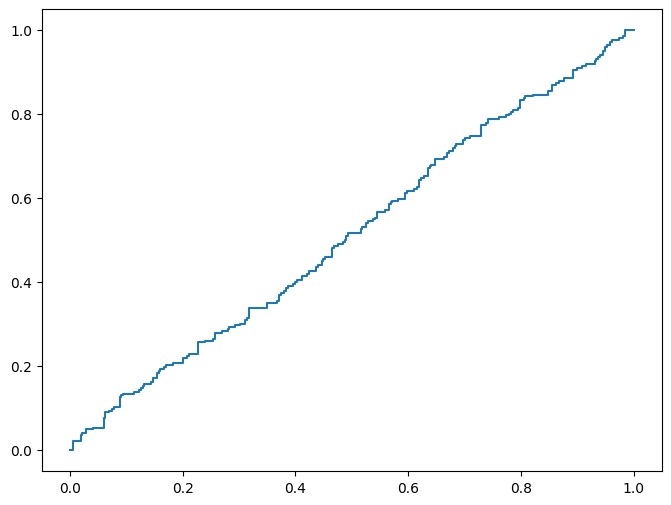

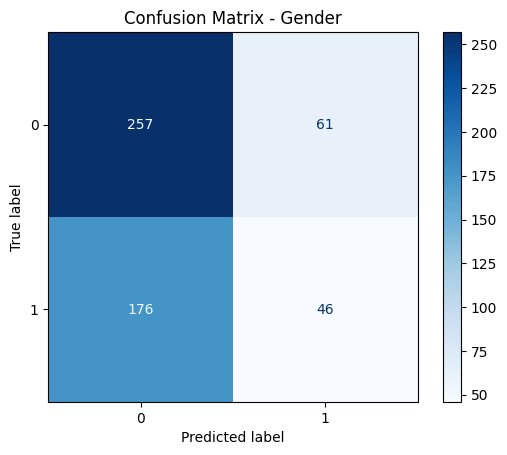

Processing Age model...
9/9 ━━━━━━━━━━━━━━━━━━━━ 337s 36s/step
Processing Handedness model...
9/9 ━━━━━━━━━━━━━━━━━━━━ 353s 38s/step


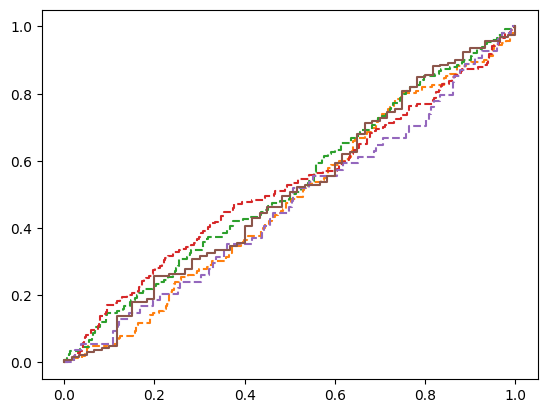

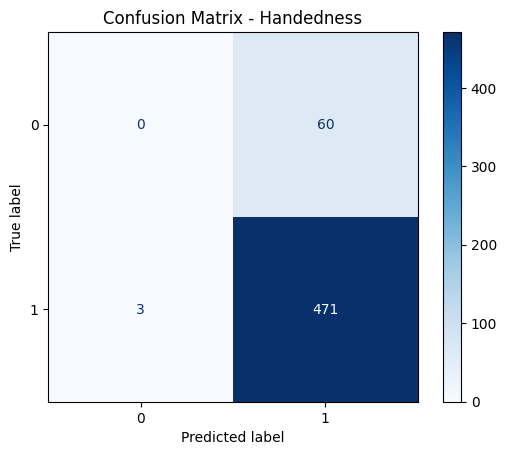

/tmp/ipython-input-2363625457.py:57: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


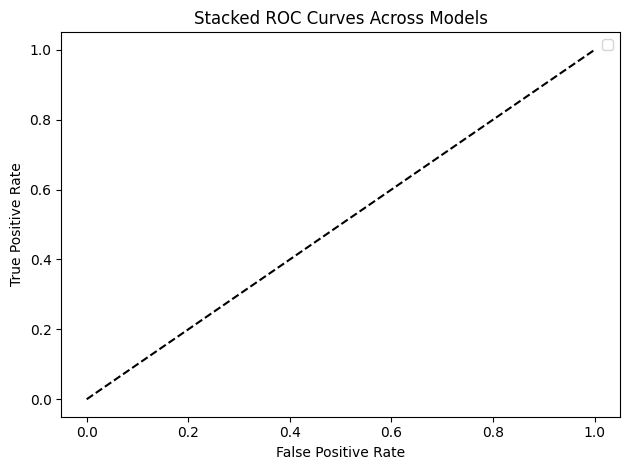

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay
)

plt.figure(figsize=(8, 6))

for (name, model), (_, test_ds) in zip(models, test_datasets):
    print(f"Processing {name} model...")

    # Extract true labels
    y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

    # Get model predictions
    y_pred = model.predict(test_ds)

    # Handle binary vs multi-class
    if y_pred.shape[1] == 1:
        # Binary classification
        y_score = y_pred.ravel()
        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc = roc_auc_score(y_true, y_score)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

        # Confusion matrix
        y_labels = (y_score > 0.5).astype(int)
        cm = confusion_matrix(y_true, y_labels)
        ConfusionMatrixDisplay(cm).plot(cmap="Blues", values_format='d')
        plt.title(f"Confusion Matrix - {name}")
        plt.show()

    else:
        # Multi-class (age model)
        # Ensure y_true is one-hot if necessary
        if y_true.ndim == 1:
            y_true_1hot = np.eye(y_pred.shape[1])[y_true.astype(int)]
        else:
            y_true_1hot = y_true

        auc = roc_auc_score(y_true_1hot, y_pred, multi_class='ovr', average='macro')
        plt.plot([], [], ' ', label=f"{name} (macro AUC = {auc:.3f})")  # dummy legend entry
        plt.show()

        # Optional: plot per-class ROC curves
        n_classes = y_pred.shape[1]
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_true_1hot[:, i], y_pred[:, i])
            plt.plot(fpr, tpr, linestyle='--', label=f"{name} class {i}")
            plt.show()


# Add random chance line + finalize ROC plot
plt.plot([0, 1], [0, 1], "k--")
plt.title("Stacked ROC Curves Across Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()

Processing Gender model...
9/9 ━━━━━━━━━━━━━━━━━━━━ 354s 38s/step


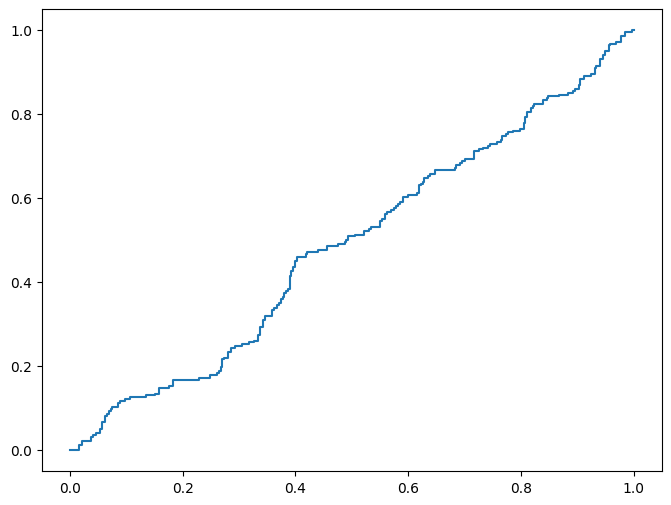

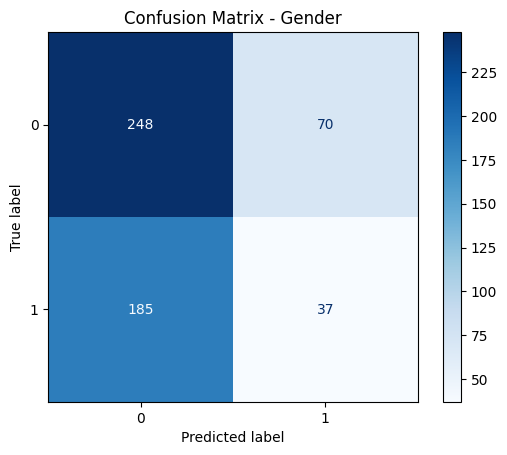

Processing Age model...
9/9 ━━━━━━━━━━━━━━━━━━━━ 344s 37s/step


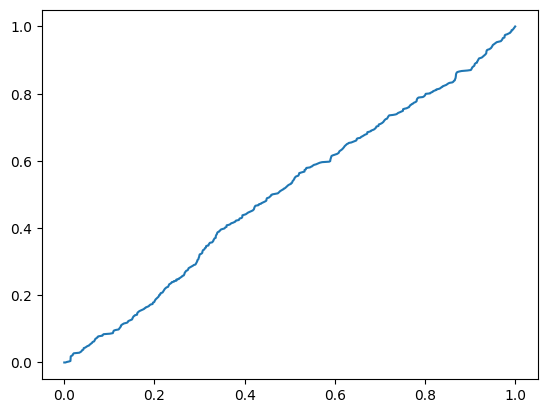

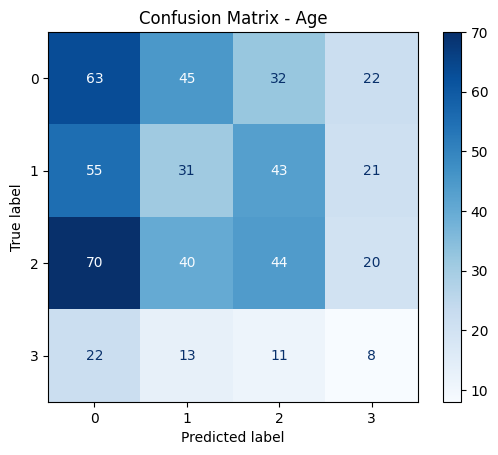

Processing Handedness model...
9/9 ━━━━━━━━━━━━━━━━━━━━ 332s 35s/step


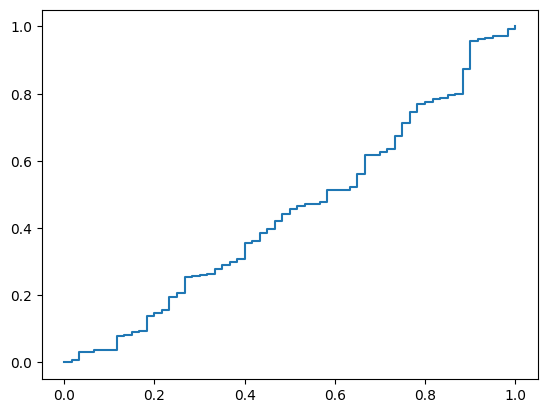

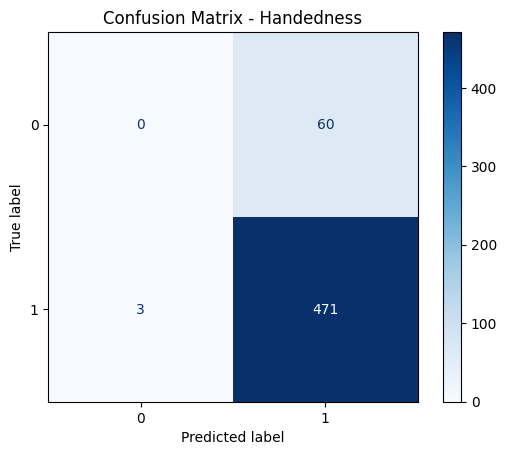

/tmp/ipython-input-3293542395.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


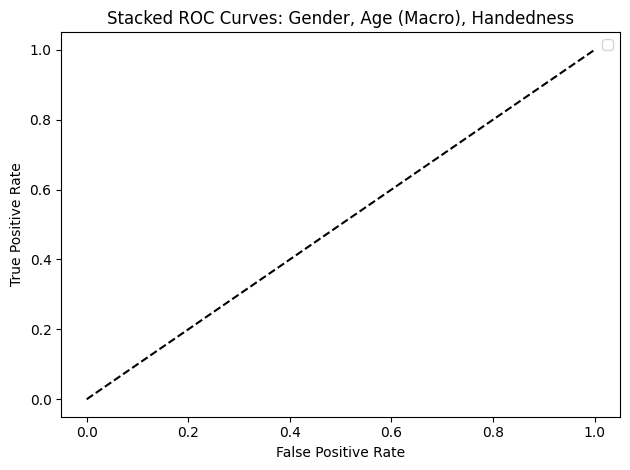

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize

plt.figure(figsize=(8, 6))

for (name, model), (_, test_ds) in zip(models, test_datasets):
    print(f"Processing {name} model...")

    # Extract true labels from tf.data.Dataset
    y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

    # Model predictions
    y_pred = model.predict(test_ds)

    # === Binary classification ===
    if y_pred.shape[1] == 1:
        y_score = y_pred.ravel()
        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc = roc_auc_score(y_true, y_score)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

        # Confusion matrix
        y_labels = (y_score > 0.5).astype(int)
        cm = confusion_matrix(y_true, y_labels)
        ConfusionMatrixDisplay(cm).plot(cmap="Blues", values_format='d')
        plt.title(f"Confusion Matrix - {name}")
        plt.show()

    # === Multi-class classification (Age) ===
    else:
        # Make sure y_true is integer-coded
        if y_true.ndim > 1:
            y_true = np.argmax(y_true, axis=1)

        # One-hot encode for roc_auc_score
        y_true_bin = label_binarize(y_true, classes=np.arange(y_pred.shape[1]))

        # Macro-average ROC (average over all classes)
        fpr_dict, tpr_dict, aucs = {}, {}, []
        all_fpr = np.unique(np.concatenate([
            roc_curve(y_true_bin[:, i], y_pred[:, i])[0] for i in range(y_pred.shape[1])
        ]))

        mean_tpr = np.zeros_like(all_fpr)
        for i in range(y_pred.shape[1]):
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
            auc = roc_auc_score(y_true_bin[:, i], y_pred[:, i])
            aucs.append(auc)
            mean_tpr += np.interp(all_fpr, fpr, tpr)

        mean_tpr /= y_pred.shape[1]
        macro_auc = np.mean(aucs)

        plt.plot(all_fpr, mean_tpr, label=f"{name} (macro AUC = {macro_auc:.3f})")

        # Confusion matrix
        y_labels = np.argmax(y_pred, axis=1)
        cm = confusion_matrix(y_true, y_labels)
        ConfusionMatrixDisplay(cm).plot(cmap="Blues", values_format='d')
        plt.title(f"Confusion Matrix - {name}")
        plt.show()

# === Combined stacked ROC plot ===
plt.plot([0, 1], [0, 1], "k--")
plt.title("Stacked ROC Curves: Gender, Age (Macro), Handedness")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()


Confusin matrix for highres models?

In [33]:
try:
    shutil.rmtree("/content/Data")
except:
    pass

source_dir = "/content/Data"

_,_,test_ds = reload_data.full_unzip_and_stratify("/content/CSAFE_Handwriting_Images.zip","/content/Data",
                                                  IMAGE_SIZE=(442, 442),BATCH_SIZE=64
                                                  )

Found 1350 files belonging to 90 classes.
Found 540 files belonging to 90 classes.
Found 540 files belonging to 90 classes.


In [30]:
highres = keras.models.load_model("/content/MobileNetV2_120.keras")

In [34]:
plt.figure(figsize=(8, 6))
name="HighRes"
model=highres

# Extract true labels
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

# Model predictions
y_pred = model.predict(test_ds)

# Handle multi-class or binary
if y_pred.shape[1] > 1:
    # Multi-class case (use class 1 for binary-like ROC)
    y_score = y_pred[:, 1]
else:
    # Binary case
    y_score = y_pred.ravel()

# Compute ROC and AUC
fpr, tpr, _ = roc_curve(y_true, y_score)
auc = roc_auc_score(y_true, y_score)
plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

# Random chance line
plt.plot([0, 1], [0, 1], "k--")
plt.title("Stacked ROC Curves Across Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 1061s 116s/step


ValueError: multiclass format is not supported

<Figure size 800x600 with 0 Axes>

In [35]:
highres.summary()

Model: "mobilenet_moreepochs"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 442, 442, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 442, 442, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 442, 442, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 14, 14, 1280)   │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 1280)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 90)             │       115,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,603,856 (9.93 MB)

 Trainable params: 115,290 (450.35 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 230,582 (900.71 KB)

In [39]:
gender.summary()

Model: "mobilenet_gender"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_2 (TrueDivide)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_2 (Subtract)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 8, 1280)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,829 (8.63 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 2,564 (10.02 KB)

Make table of

    train acc - test acc - major class %

In [40]:
age_metrics = pd.read_csv("/content/age_lossacc.csv")
gender_metrics = pd.read_csv("/content/gender_lossacc.csv")
hand_metrics = pd.read_csv("/content/hand_lossacc.csv")

In [45]:
hand_metrics.iloc[69]

,69
Unnamed: 0,69.000000
acc,0.895880
loss,0.262491
val_acc,0.897004
val_loss,0.371898


In [62]:
test_acc = {
    "Gender":0.722,
    "Age":0.637,
    "Hand":0.891,
    "Author":0.791
}
train_acc = {
    "Gender":0.693,
    "Age":0.647,#
    "Hand":0.896,
    "Author":0.86
}
classper = {
    "Gender":0.60,
    "Age":0.33,#
    "Hand":0.90,
    "Author":0.01
}

In [61]:
df=pd.read_csv("/content/CSAFE_Handwriting_Info.csv")
df["wid"].value_counts()/90

,count
wid,
35,0.011111
75,0.011111
128,0.011111
152,0.011111
63,0.011111
...,...
130,0.011111
38,0.011111
27,0.011111


In [63]:
pd.DataFrame([train_acc,test_acc,classper],index=["Train Acc.","Test Acc.","Major Class %"])

,Gender,Age,Hand,Author
Train Acc.,0.693,0.647,0.896,0.860
Test Acc.,0.722,0.637,0.891,0.791
Major Class %,0.600,0.330,0.900,0.010
